# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, transfering, and extending of HBR models. 

### Imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.prior import make_prior
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import arviz as az

import pymc.math as math


# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [13]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=("transfer", "fit")
)

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [14]:
save_dir = "resources/hbr/save_dir"
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir=save_dir,
    inscaler="standardize",
    outscaler="standardize",
    basis_function="linear",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a Normal likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. We also use the mapping_params to scale the mapping by a factor of 3, to avoid spikes in the resulting density. 

In [15]:
mu = make_prior(
    name="mu",
    linear=True,
    # slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    slope=make_prior(random=False),
    intercept=make_prior(
        random=True,
        sigma=make_prior(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_prior(
    name="sigma",
    linear=False,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_prior(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_prior(
    name="epsilon",
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)

delta = make_prior(
    name="delta",
    dist_name="Normal",
    dist_params=(1.0, 1.0),
    mapping="softplus",
    mapping_params=(0.0, 2.0, 0.3),
)


# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=2048,
    tune=512,
    chains=4,
    pymc_cores=16,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
    nuts_sampler="nutpie",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [16]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [17]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

In [18]:
# predictions = norm_hbr.fit_predict(train, test)
norm_hbr.fit_predict(train, test)


Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,188,0,0.00,1023
,221,0,0.00,1023
,188,0,0.00,1023
,193,0,0.00,1023


## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

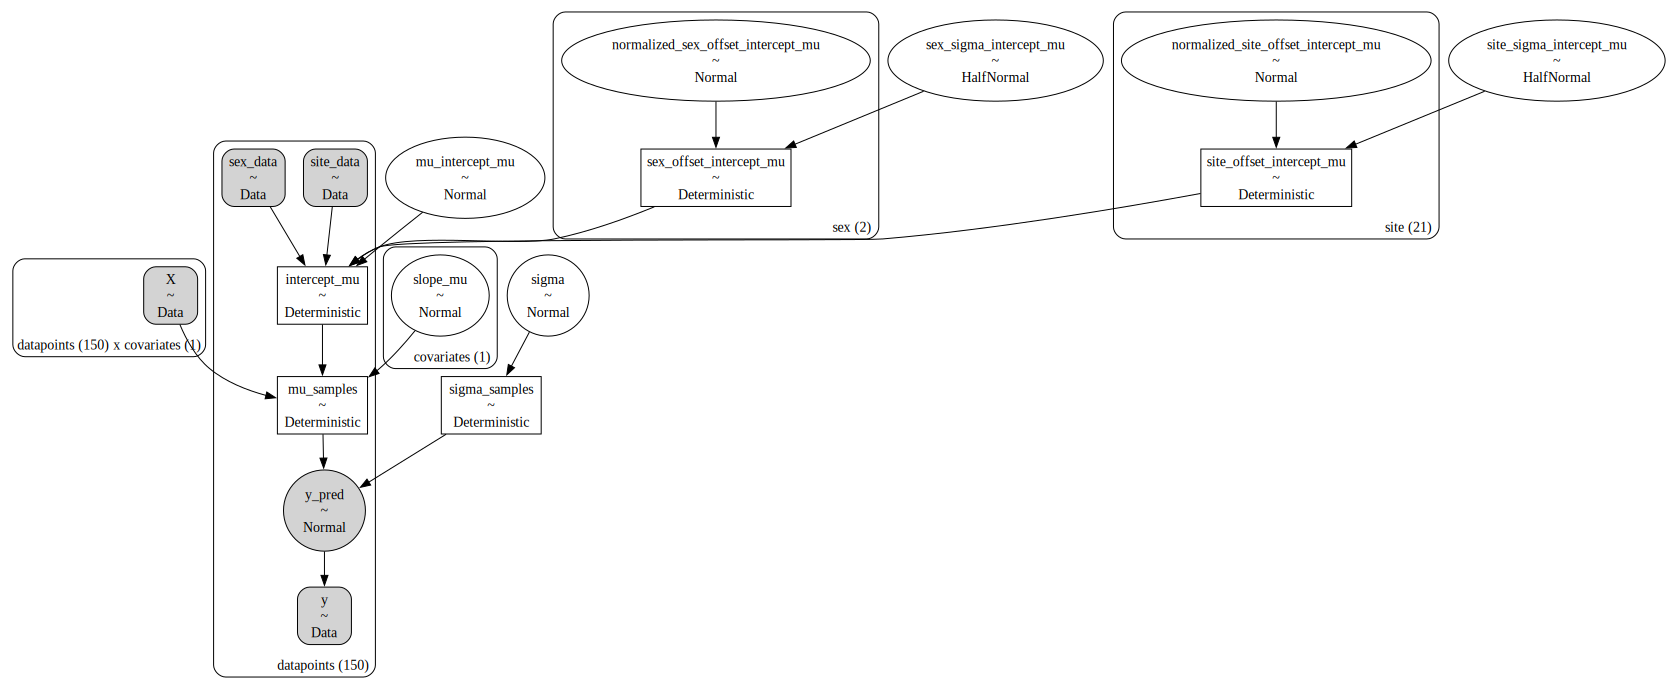

In [8]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


In [ ]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~mu_samples",
        "~sigma_samples",
        "~epsilon_samples",
        "~delta_samples",
        "~intercept_mu",
        "~scaled_site_offset_intercept_mu",
        "~scaled_sex_offset_intercept_mu",
    ],
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [ ]:
display(test.measures.to_pandas().T)


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [ ]:
display(test.zscores.to_pandas())  # the zscores

In [ ]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

In [ ]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

In [ ]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


In [ ]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

If we transfer to new dataset, we use the samples from the posterior to derive priors for a new model. That new model is then fitted on the new dataset. Our new model will not work on the old data. To give some extra control over the fit, we let the `freedom` parameter control the variance of the derived factorized posterior. Here we set it to something small (1e-4) to create a spike prior on the model parameters, to ensure that we do not 'forget' about what we learned from the original data. If we have a very large new dataset, we can set the freedom parameter to something bigger. 

In [ ]:
from pcntoolkit.normative_model.norm_factory import load_normative_model

save_dir = "resources/hbr/save_dir"
model = load_normative_model(save_dir)

transfered_model = model.transfer_predict(
    transfer_train, transfer_test, freedom=1e-4, nuts_sampler="nutpie"
)

In [ ]:
transfered_model.predict(transfer_test)

We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path.

### Extend

Extending a model on new data amounts to generating synthetic data according to the learned distribution, merging that with the new data, and fitting a new model on that merged dataset. This enables true federated learning, because the original data does not need to be shipped with the model to extend it to a new dataset. 

Because this is an extended model, we can make predictions on all sites, even those that were only present in the original data. 

In [ ]:
save_dir = "resources/hbr/save_dir"
from pcntoolkit.normative_model.norm_factory import load_normative_model

model = load_normative_model(save_dir)

extended_model = model.extend_predict(transfer_train, transfer_test)

In [ ]:
extended_model.predict(test)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset
- Extend the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!